In [1]:
import glob
import csv
import sys, os.path
import pandas as pd
import sklearn
import torch
from torch import optim, nn
from torch.utils.data import DataLoader
from torchvision import transforms
#from torch.utils.tensorboard import SummaryWriter
#from torchsummary import summary
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Our modules
import sys
sys.path.append('.')
sys.path.append('..')

from vae import configs, train, plot_utils, models
from vae.data import build_dataloader
from vae.latent_spaces import dimensionality_reduction, plot_spaces
from vae.reconstructions import plot_reconstructions
from vae.models import model_utils

In [3]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc * 100)
    
    return acc

In [4]:
classes = ['violin', 'viola', 'cello', 'double-bass',
                'clarinet', 'bass-clarinet', 'saxophone', 'flute', 'oboe', 'bassoon', 'contrabassoon',
                'french-horn', 'trombone', 'trumpet', 'tuba', 'english-horn',
                'guitar', 'mandolin', 'banjo', 'chromatic-percussion']

chromatic_perc = ['agogo-bells', 'banana-shaker', 'bass-drum', 'bell-tree', 'cabasa', 'Chinese-hand-cymbals',
                        'castanets', 'Chinese-cymbal', 'clash-cymbals', 'cowbell', 'djembe', 'djundjun', 'flexatone', 'guiro',
                        'lemon-shaker',  'motor-horn',  'ratchet', 'sheeps-toenails', 'sizzle-cymbal', 'sleigh-bells', 'snare-drum',
                        'spring-coil', 'squeaker', 'strawberry-shaker', 'surdo', 'suspended-cymbal', 'swanee-whistle',
                        'tambourine', 'tam-tam', 'tenor-drum', 'Thai-gong', 'tom-toms', 'train-whistle', 'triangle',
                        'vibraslap', 'washboard', 'whip', 'wind-chimes', 'woodblock']

labels_list = [i for i in range(len(classes))]

In [5]:
# Create dict of classes
classes_dict = {classes[i]: classes.index(classes[i]) for i in range(len(classes))}


df = pd.DataFrame.from_dict(classes_dict, orient='index', columns=['class'])

In [6]:
df

,class
violin,0
viola,1
cello,2
double-bass,3
clarinet,4
bass-clarinet,5
saxophone,6
flute,7
oboe,8
bassoon,9


In [7]:
model_name = 'supervised_timbre'
input = 'mel_cut'
trained_epochs = 280


test_dataset, test_dataloader = build_dataloader.build_testset(input, model_name)
print('Number of files in the training dataset:', len(test_dataset))

Number of files in the training dataset: 2051


In [8]:
model = model_utils.import_model(model_name, input)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
checkpoint = torch.load(os.path.join(configs.ParamsConfig.TRAINED_MODELS_PATH, 'saved_model_' + str(trained_epochs) + "epochs.pth"))
model.load_state_dict(checkpoint['model'])
with torch.no_grad():
    model.eval()
    
    y_pred_list = []
    y_test_list = []
    for sample_batch, y in test_dataloader:
            sample_batch = sample_batch.to(device, dtype=torch.float)
            y_test_list.append(y)
            y_test_pred = model(sample_batch)
            _, y_pred_tags = torch.max(y_test_pred, dim = 1)
            y_pred_list.append(y_pred_tags.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
y_test = [a.squeeze().tolist() for a in y_test_list]

In [9]:
model_utils.show_total_params(model)

Number of parameters: 122388
AttentionTimbreEncoder(
  (multihead_attn): MultiheadAttention(
    (out_proj): _LinearWithBias(in_features=128, out_features=128, bias=True)
  )
  (fc_1): Linear(in_features=2816, out_features=20, bias=True)
)


In [10]:
assert y_pred_list != y_test

In [11]:
from sklearn.metrics import confusion_matrix, classification_report
confusion_matrix(y_test, y_pred_list)

array([[ 76,  25,   3,   0,   3,   0,  11,   2,   2,   1,   0,   3,  19,
          2,   0,   3,   0,   2,   0,  73],
       [  4,  92,   3,   1,   3,   0,   9,   6,   4,   0,   2,   0,   5,
          1,   2,   0,   0,   1,   0,  13],
       [  3,   9,  43,   1,   4,   5,  23,   0,   3,   0,   6,   0,  13,
          1,  14,   2,   0,   2,   0,   4],
       [  1,  12,   5,  69,   1,   4,   2,   1,   0,   1,   3,   0,  26,
          0,   3,   0,   0,   0,   0,   0],
       [ 13,   7,   5,   1,  42,   7,  25,   6,   0,   0,   0,   1,   9,
          0,   0,   3,   0,   0,   0,   8],
       [  0,  21,  12,  27,   0,  24,  12,   0,   0,   7,   0,   1,  11,
          0,   4,  17,   0,   1,   0,   5],
       [  8,  16,   0,   0,   5,   0,  53,   1,   0,   7,   0,   3,  12,
          0,   2,   1,   0,   0,   1,   1],
       [  1,   5,  17,   2,  15,   0,   3,  53,  21,   1,   0,   3,   1,
          1,   1,   0,   0,   1,   0,   7],
       [  0,   3,   6,   0,   1,   0,   1,   5,  58,   0,   0,  

In [12]:
idx_class = {v: k for k, v in classes_dict.items()}

confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test, y_pred_list)).rename(columns=idx_class, index=idx_class)

<AxesSubplot:>

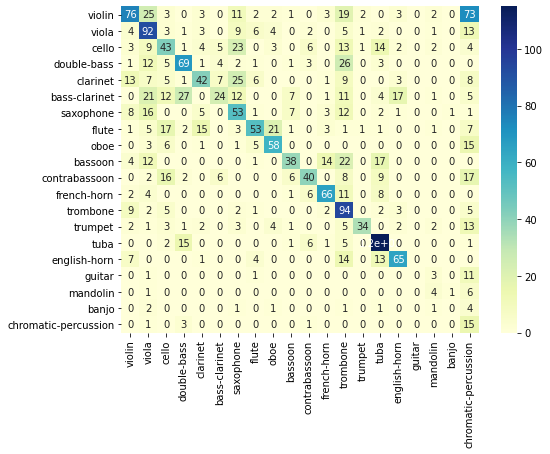

In [13]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(8, 6)) 
sns.heatmap(confusion_matrix_df, annot=True, cmap="YlGnBu", ax=ax)

<AxesSubplot:>

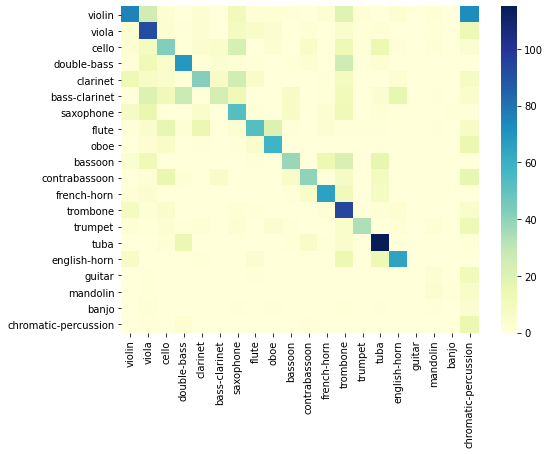

In [14]:
fig, ax = plt.subplots(figsize=(8, 6)) 
sns.heatmap(confusion_matrix_df, annot=False, cmap="YlGnBu", ax=ax)

In [15]:
print(classification_report(y_test, y_pred_list))

              precision    recall  f1-score   support

           0       0.58      0.34      0.43       225
           1       0.43      0.63      0.51       146
           2       0.36      0.32      0.34       133
           3       0.57      0.54      0.55       128
           4       0.55      0.33      0.41       127
           5       0.52      0.17      0.26       142
           6       0.37      0.48      0.42       110
           7       0.65      0.40      0.50       132
           8       0.62      0.65      0.64        89
           9       0.59      0.35      0.44       108
          10       0.62      0.38      0.47       106
          11       0.70      0.67      0.69        98
          12       0.37      0.75      0.49       125
          13       0.87      0.47      0.61        73
          14       0.60      0.79      0.68       146
          15       0.68      0.62      0.65       104
          16       0.00      0.00      0.00        16
          17       0.24    

## References

* https://towardsdatascience.com/pytorch-tabular-multiclass-classification-9f8211a123ab

In [24]:
path = 'H:\\GitHub\\note-vae\\data\\mels\\train\\' + 'violin_E7_1_forte_arco-normal' + '.npy'
import matplotlib.pyplot as plt
path = np.load(path)

In [25]:
import sklearn
def normalize(input_rep):
    normalized_mel = sklearn.preprocessing.normalize(X=input_rep, norm='l2', axis=0)
    return normalized_mel

def cut_silence(cqt, threshold=0.1):
    first_frame = 0
    for frame in range(0, cqt.shape[1], 1):
        max_value = np.max(cqt[:, frame])
        if max_value > threshold:
            first_frame = frame
            break
        else:
            continue

    last_frame = cqt.shape[1]
    for frame in range(cqt.shape[1]-1, 0, -1):
        max_value = np.max(cqt[:, frame])
        if max_value > threshold:
            last_frame = frame
            break
        else:
            continue

    return cqt[:, first_frame:last_frame]

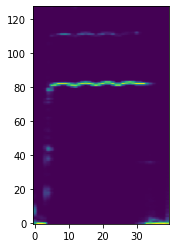

In [28]:
mel_compressed = cut_silence(path)
mel_norm_compressed = normalize(mel_compressed)
plt.imshow(mel_norm_compressed, origin='lower', aspect=0.5)